In [ ]:
using Revise
using Pkg
Pkg.develop(path="/data/gpfs/projects/punim0638/stephenz/locaTE.jl")

In [1]:
using Random
using LinearAlgebra
using NPZ
using locaTE
using OptimalTransport
using StatsBase
using SparseArrays

In [2]:
DATA_DIR = "../data/simulated/Synthetic_1000/dyn-LI/dyn-LI-1000-1/"

"../data/simulated/Synthetic_1000/dyn-LI/dyn-LI-1000-1/"

In [3]:
X = npzread(string(DATA_DIR, "X.npy"));
P = npzread(string(DATA_DIR, "P_velo_dot.npy"))^3;
C = npzread(string(DATA_DIR, "C.npy"));
dpt = npzread(string(DATA_DIR, "dpt.npy"));
R = quadreg(ones(size(X, 1)), ones(size(X, 1)), C, 2.5*mean(C));
J = npzread(string(DATA_DIR, "J.npy"));
G = npzread(string(DATA_DIR, "locate_output_3_25_0.001/mi_velo_dot.npy"));
QT = to_backward_kernel(P)';

In [4]:
P_sp = sparse(P);
QT_sp = sparse(QT);
R_sp = sparse(R);

In [5]:
A_ref = mean(J; dims = 1)[1, :, :];

In [6]:
i = sortperm(dpt)[1]
gamma = (compute_coupling(X, i, sparse(P), sparse(QT), sparse(R)));

In [7]:
using Einsum

In [8]:
X_intercept = hcat(ones(size(X, 1)), X);

In [9]:
# function solve_lin(gamma; λ = 1e-2)
#     lhs = sum([v*vcat(1, X[k, :])*vcat(1, X[k, :])' for (k, l, v) in zip(findnz(gamma)...)])
#     rhs = sum([v*vcat(1, X[k, :])*(X[l, :]-X[k, :])' for (k, l, v) in zip(findnz(gamma)...)])
#     return ((lhs + λ*I) \ rhs)[2:end, :]'
# end
# 
function solve_lin(gamma; λ = 0)
    lhs = sum([v*X[k, :]*X[k, :]' for (k, l, v) in zip(findnz(gamma)...)])
    rhs = sum([v*X[k, :]*(X[l, :]-X[k, :])' for (k, l, v) in zip(findnz(gamma)...)])
    return ((lhs + λ*I) \ rhs)'
end

solve_lin (generic function with 1 method)

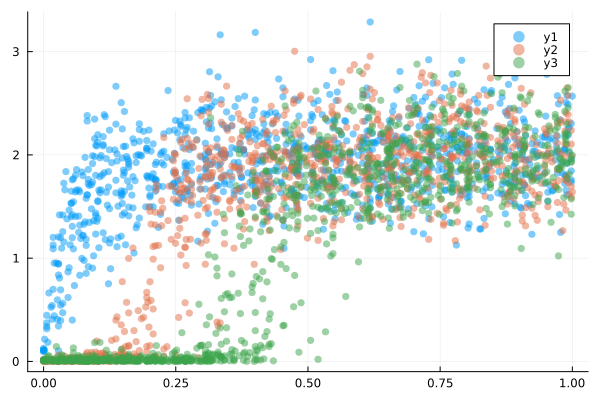

In [10]:
using Plots
plt=plot()
[scatter!(dpt, x; markerstrokewidth = 0, alpha = 0.5) for x in eachcol(X[:,2:4])]
plt

In [11]:
using InformationMeasures
import locaTE.get_MI

In [164]:
function get_MI( 
    X::AbstractMatrix,
    coupling::AbstractSparseMatrix,
    genes_prev::Vector{Int},
    genes_next::Vector{Int};
    disc = nothing,
    kwargs...,
)
    @assert length(genes_prev) == length(genes_next)
    mi = zeros(length(genes_prev))
    row_idxs, row_map, col_idxs, col_map = locaTE.construct_index_maps(coupling)
    # discretize each gene separately
    disc_prev =
        disc === nothing ?
        [locaTE.discretization(X[row_idxs, i]; kwargs...) for i = 1:size(X, 2)] :
        [(x[1], x[2][row_idxs]) for x in disc]
    disc_next =
        disc === nothing ?
        [locaTE.discretization(X[col_idxs, i]; kwargs...) for i = 1:size(X, 2)] :
        [(x[1], x[2][col_idxs]) for x in disc]
    for j = 1:length(genes_prev)
        try
            p = locaTE.discretized_joint_distribution(
                coupling,
                X,
                genes_prev[j],
                genes_next[j],
                row_idxs,
                col_idxs,
                row_map,
                col_map,
                disc_prev,
                disc_next;
                kwargs...,
            )
            # mi[j] = get_entropy(p)
            # mi[j] = get_mutual_information(sum(p; dims = 3)[:, :, 1]) 
            mi[j] = get_conditional_mutual_information(p)
            if genes_prev[j] == 2 && genes_next[j] == 3
                @info mi[j]
            end
        catch e
            mi[j] = 0
        end
    end
    mi
end

get_MI (generic function with 1 method)

In [165]:
using Discretizers
using Base.Iterators

[ Info: 0.0239095059902365


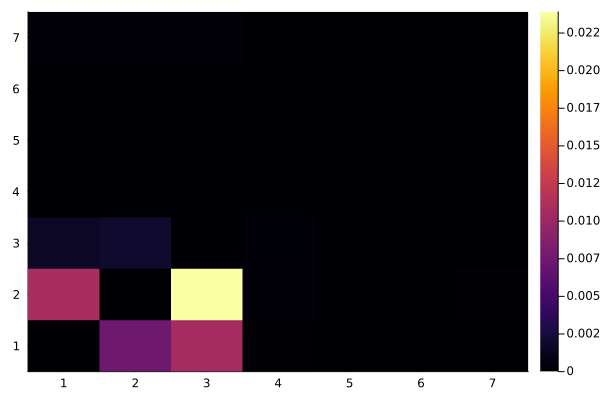

In [166]:
i = sortperm(dpt)[75]
disc = collect(locaTE.discretizations_bulk(X; alg = DiscretizeUniformWidth(:scott)));
gamma = compute_coupling(X, i, P_sp, QT_sp, R_sp)
genes_prev = vec(first.(product(1:size(X, 2), 1:size(X, 2))));
genes_next = vec(last.(product(1:size(X, 2), 1:size(X, 2))));
A = get_MI(X, sparse(gamma), genes_prev, genes_next; disc = disc)
heatmap(reshape(A, size(X, 2), size(X, 2)))

In [167]:
row_idxs, row_map, col_idxs, col_map = locaTE.construct_index_maps(gamma)
disc_prev = [(x[1], x[2][row_idxs]) for x in disc]
disc_next = [(x[1], x[2][col_idxs]) for x in disc]
p = locaTE.discretized_joint_distribution(gamma, X, 2, 3, row_idxs, col_idxs, row_map, col_map, disc_prev, disc_next);
get_conditional_mutual_information(p)

0.0239095059902365

In [157]:
dot([get_mutual_information(normalize(p[:, :, i], 1)) for i = 1:size(p, 3)], sum(p; dims = (1, 2)))

0.02390950599010882

In [158]:
[get_mutual_information(normalize(p[:, :, i], 1)) for i = 1:size(p, 3)]

11-element Vector{Float64}:
 0.02457914498882001
 0.011910624852909028
 0.015822017480450402
 0.01303804593360219
 0.001768169074801288
 0.054006632488714346
 0.20786513319155792
 0.12049370417358342
 0.0
 6.719438532720699e-17
 0.0

[ Info: 0.20786513319155794


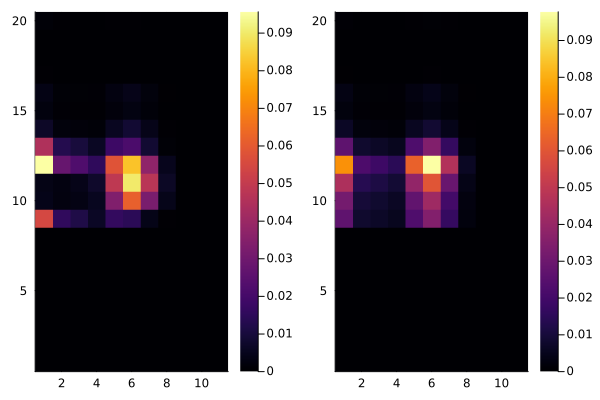

In [159]:
q = p[:, :, 7] 
q ./= sum(q)
@info get_mutual_information(q)
plot(heatmap(q),
     heatmap(sum(q; dims = 2) .* sum(q; dims = 1)))

[ Info: Float32[2.0476031, 0.86705065, 2.0348793f-5, 0.01426549, 0.037482865, 0.15785067, 0.021249315]


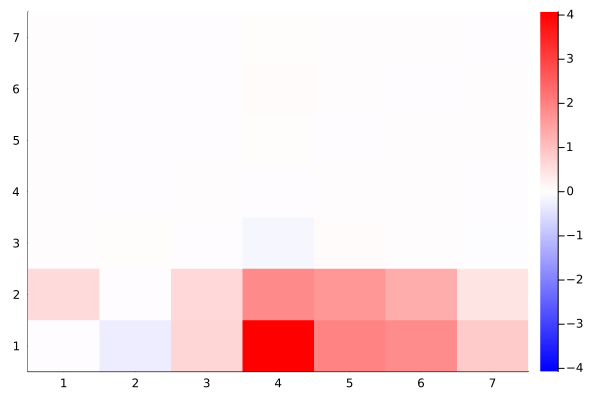

In [26]:
@info X[i, :]
gamma = compute_coupling(X, i, P_sp, QT_sp, R_sp)
A = solve_lin(gamma)
A[diagind(A)] .= 0
heatmap(A, c = :bwr, clim = (-maximum(abs.(A)), maximum(abs.(A))))

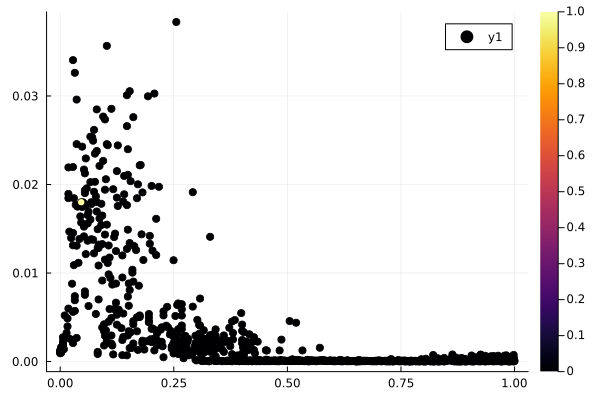

In [136]:
scatter(dpt, reshape(G, :, size(X, 2), size(X, 2))[:, 2, 3], marker_z = (1:size(X, 1) .== i))

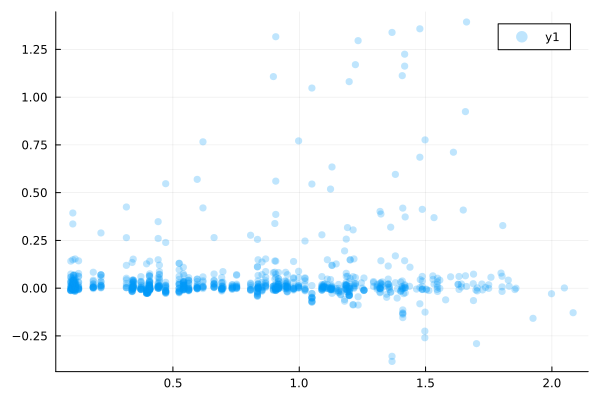

In [137]:
using Distributions
using Base.Iterators
using Discretizers
spt = vec(collect(product(1:size(X, 1), 1:size(X, 1))))
samp = rand(DiscreteNonParametric(1:length(spt), vec(Array(gamma))), 1000)

scatter([X[i, 2] for (i, j) in spt[samp]], 
        [X[j, 3]-X[i, 3] for (i, j) in spt[samp]], alpha = 0.25, markerstrokewidth = 0)

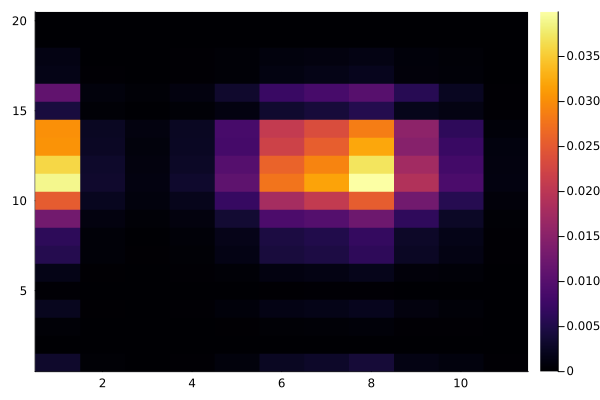

In [20]:
disc = collect(locaTE.discretizations_bulk(X; alg = DiscretizeUniformWidth(:scott)));
row_idxs, row_map, col_idxs, col_map = locaTE.construct_index_maps(gamma)
p = locaTE.discretized_joint_distribution(gamma, X, 2, 3, row_idxs, col_idxs, row_map, col_map, disc, disc)
heatmap(sum(p; dims = 3)[:, :, 1])

In [21]:
using Base.Iterators

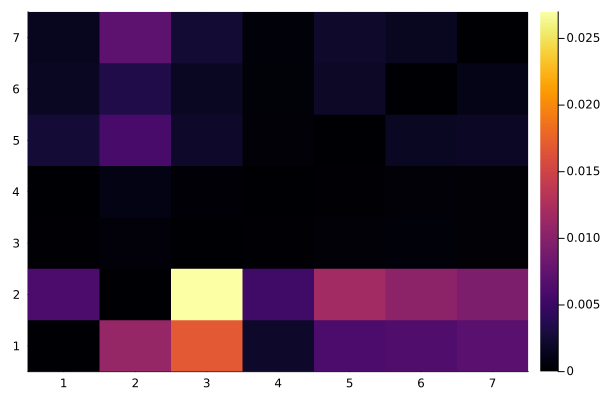

In [22]:
genes_prev = vec(first.(product(1:size(X, 2), 1:size(X, 2))));
genes_next = vec(last.(product(1:size(X, 2), 1:size(X, 2))));
A = reshape(get_MI(X, sparse(gamma), genes_prev, genes_next; disc = nothing, alg = DiscretizeUniformWidth(:scott)), size(X, 2), size(X, 2))
heatmap(A)

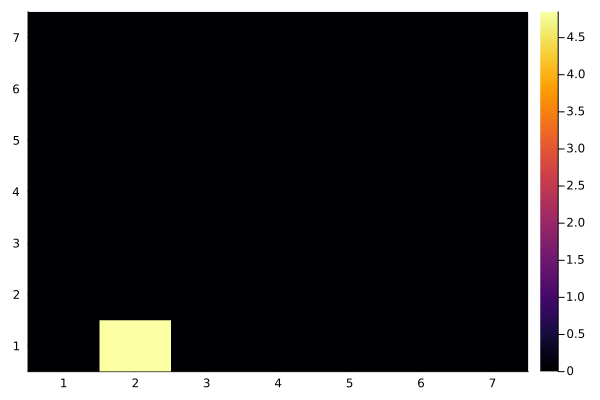

In [23]:
heatmap(J[i, :, :]')

In [24]:
A_te = reshape(mean(G; dims = 1), size(X, 2), size(X, 2));

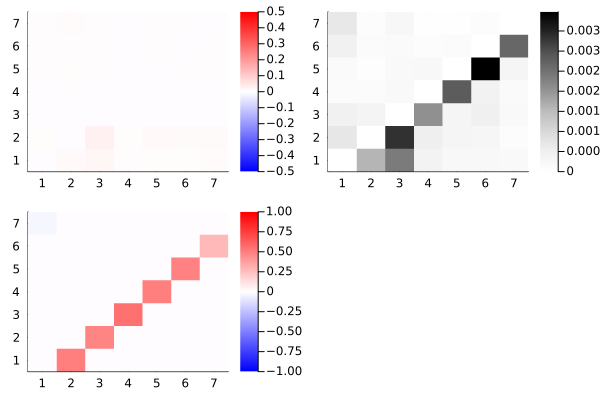

In [25]:
using Plots
plot(heatmap(A; c = :bwr, clim = (-0.5, 0.5)), 
    heatmap(A_te; c = :Greys),
    heatmap(A_ref'; c = :bwr, clim = (-1, 1)))

In [526]:
X = rand(1000, 16);

# construct jacobian
J = zeros(size(X, 2), size(X, 2))
for i = 1:(size(X, 2)-1)
    J[i, i+1] = rand() > 0.5 ? -1 : 1 
end

# initial state
x0 = rand(size(X, 1), size(X, 2))
τ = 1.0

x1 = x0 + τ*(J * x0')' + randn(size(x0)...)*0.25

X = vcat(x0, x1);
coupling = kron([0.0 1.0; 0.0 0.0], I(size(x0, 1)))
coupling ./= sum(coupling);
coupling_rand = sum([Array{Float64}(I(size(coupling, 1))[randperm(size(coupling, 1)), :][:, randperm(size(coupling, 1))]) for _ = 1:10])
coupling_rand ./= sum(coupling_rand)

ρ = 0.5
coupling = ρ*coupling + (1-ρ)*coupling_rand;

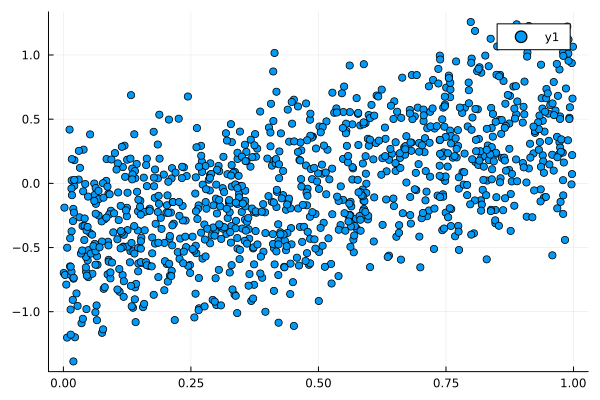

In [527]:
scatter(x0[:, 1], x1[:, 1])

In [528]:
using Discretizers
using Base.Iterators

In [529]:
A = solve_lin(coupling)
SNR = mean(abs.(A[J .!= 0])) ./ mean(abs.(A[J .== 0]))
A[diagind(A)] .= 0
# plt1 = heatmap(A, clim = (-maximum(abs.(A)), maximum(abs.(A))), c = :bwr, title = "Linear: SNR = $SNR");
plt1 = heatmap(abs.(A), title = "Linear: SNR = $SNR");
plt2 = heatmap(J; c = :bwr, clim = (-1, 1))
genes_prev = vec(last.(product(1:size(X, 2), 1:size(X, 2))));
genes_next = vec(first.(product(1:size(X, 2), 1:size(X, 2))));
A = reshape(get_MI(X, sparse(coupling), genes_prev, genes_next; disc = nothing, alg = DiscretizeUniformWidth(:scott)), size(X, 2), size(X, 2))
SNR = mean(A[J .!= 0]) ./ mean(A[J .== 0])
plt3= heatmap(A; title = "TE: SNR = $SNR");

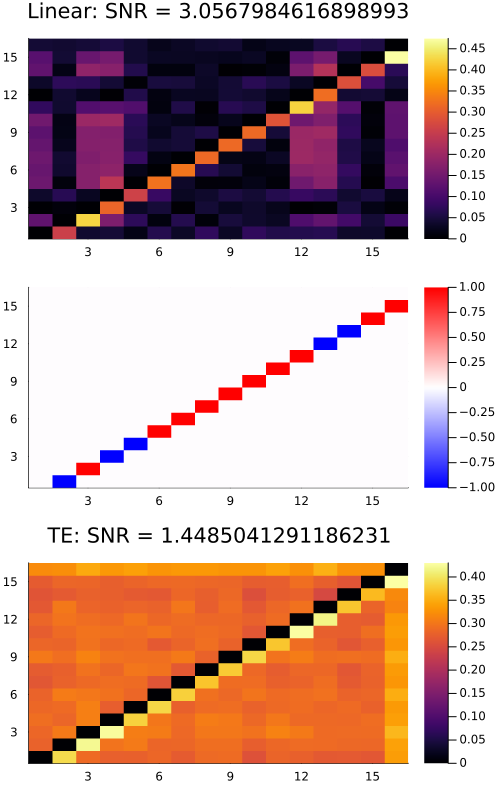

In [530]:
plot(plt1, plt2, plt3; layout = (3, 1), size = (500, 800))